# Color UMAP by Causal Norm

Load the 64k UMAP embedding and visualize with blackbody colormap based on causal norms.

**Inputs:**
- `data/vectors/umap_embedding_64k.npy` - 2D UMAP coordinates
- `data/vectors/distances_causal_64000.pt` - Token indices
- `data/vectors/causal_metric_tensor_qwen3_4b.pt` - Metric tensor M
- Model unembedding matrix γ

**Output:**
- Scatterplot colored by causal norm (blackbody colormap)

# Input files
EMBEDDING_FILE = '../data/vectors/umap_embedding_32k.npy'
DISTANCES_FILE = '../data/vectors/distances_causal_32000.pt'
METRIC_FILE = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

print(f"Configuration:")
print(f"  Embedding: {EMBEDDING_FILE}")
print(f"  Model: {MODEL_NAME}")

In [9]:
# Input files
EMBEDDING_FILE = '../data/vectors/umap_embedding_32k.npy'
DISTANCES_FILE = '../data/vectors/distances_causal_32000.pt'
METRIC_FILE = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

print(f"Configuration:")
print(f"  Embedding: {EMBEDDING_FILE}")
print(f"  Model: {MODEL_NAME}")

Configuration:
  Embedding: ../data/vectors/umap_embedding_32k.npy
  Model: Qwen/Qwen3-4B-Instruct-2507


## Setup

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from transformers import AutoModelForCausalLM

print("✓ Imports complete")

✓ Imports complete


print(f"\nLoading metric tensor from {METRIC_FILE}...")
metric_data = torch.load(METRIC_FILE, weights_only=False)
M = metric_data['M'].to('cpu')  # Move to CPU to match gamma

print(f"✓ Loaded metric tensor")
print(f"  Shape: {M.shape}")
print(f"  Device: {M.device}")

print(f"\nLoading model to extract unembedding matrix...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map='cpu',
)
gamma = model.lm_head.weight.data.clone()  # [vocab_size, 2560]

# Get embeddings for sampled tokens
sampled_gamma = gamma[token_indices]  # [32000, 2560]

print(f"✓ Loaded token embeddings")
print(f"  Shape: {sampled_gamma.shape}")
print(f"  Device: {sampled_gamma.device}")

# Free model memory
del model
print(f"✓ Freed model memory")

In [11]:
print(f"Loading UMAP embedding from {EMBEDDING_FILE}...")
embedding = np.load(EMBEDDING_FILE)

print(f"✓ Loaded embedding")
print(f"  Shape: {embedding.shape}")
print(f"  X range: [{embedding[:, 0].min():.2f}, {embedding[:, 0].max():.2f}]")
print(f"  Y range: [{embedding[:, 1].min():.2f}, {embedding[:, 1].max():.2f}]")

Loading UMAP embedding from ../data/vectors/umap_embedding_32k.npy...
✓ Loaded embedding
  Shape: (32000, 2)
  X range: [3.08, 10.08]
  Y range: [7.55, 14.01]


## Load Token Indices

In [12]:
print(f"\nLoading token indices from {DISTANCES_FILE}...")
data = torch.load(DISTANCES_FILE, weights_only=False)
token_indices = data['token_indices']

print(f"✓ Loaded token indices")
print(f"  N tokens: {len(token_indices):,}")


Loading token indices from ../data/vectors/distances_causal_32000.pt...
✓ Loaded token indices
  N tokens: 32,000


## Load Metric Tensor and Unembedding Matrix

In [15]:
print(f"\nLoading metric tensor from {METRIC_FILE}...")
metric_data = torch.load(METRIC_FILE, weights_only=False)
M = metric_data['M'].to('cpu')  # [2560, 2560]

print(f"✓ Loaded metric tensor")
print(f"  Shape: {M.shape}")

print(f"\nLoading model to extract unembedding matrix...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map='cpu',
)
gamma = model.lm_head.weight.data.clone()  # [vocab_size, 2560]

# Get embeddings for sampled tokens
sampled_gamma = gamma[token_indices]  # [64000, 2560]

print(f"✓ Loaded token embeddings")
print(f"  Shape: {sampled_gamma.shape}")

# Free model memory
del model
print(f"✓ Freed model memory")


Loading metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...
✓ Loaded metric tensor
  Shape: torch.Size([2560, 2560])

Loading model to extract unembedding matrix...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Loaded token embeddings
  Shape: torch.Size([32000, 2560])
✓ Freed model memory


## Compute Causal Norms

In [16]:
print("\nComputing causal norms: ||γ||_M = sqrt(γ^T M γ)...")

# Batch computation to avoid memory issues
batch_size = 1000
causal_norms = []

for i in range(0, len(sampled_gamma), batch_size):
    batch = sampled_gamma[i:i+batch_size]  # [batch, 2560]
    M_batch = torch.matmul(batch, M)  # [batch, 2560]
    norms_squared = (batch * M_batch).sum(dim=1)  # [batch]
    causal_norms.append(torch.sqrt(torch.clamp(norms_squared, min=0)))

causal_norms = torch.cat(causal_norms).numpy()

print(f"✓ Computed causal norms")
print(f"  Min: {causal_norms.min():.2f} logometers")
print(f"  Max: {causal_norms.max():.2f} logometers")
print(f"  Mean: {causal_norms.mean():.2f} logometers")
print(f"  Median: {np.median(causal_norms):.2f} logometers")
print(f"  Std: {causal_norms.std():.2f} logometers")
print(f"  CV: {causal_norms.std() / causal_norms.mean() * 100:.1f}%")


Computing causal norms: ||γ||_M = sqrt(γ^T M γ)...
✓ Computed causal norms
  Min: 21.45 logometers
  Max: 75.08 logometers
  Mean: 54.12 logometers
  Median: 55.26 logometers
  Std: 7.95 logometers
  CV: 14.7%


## Visualize with Blackbody Colormap

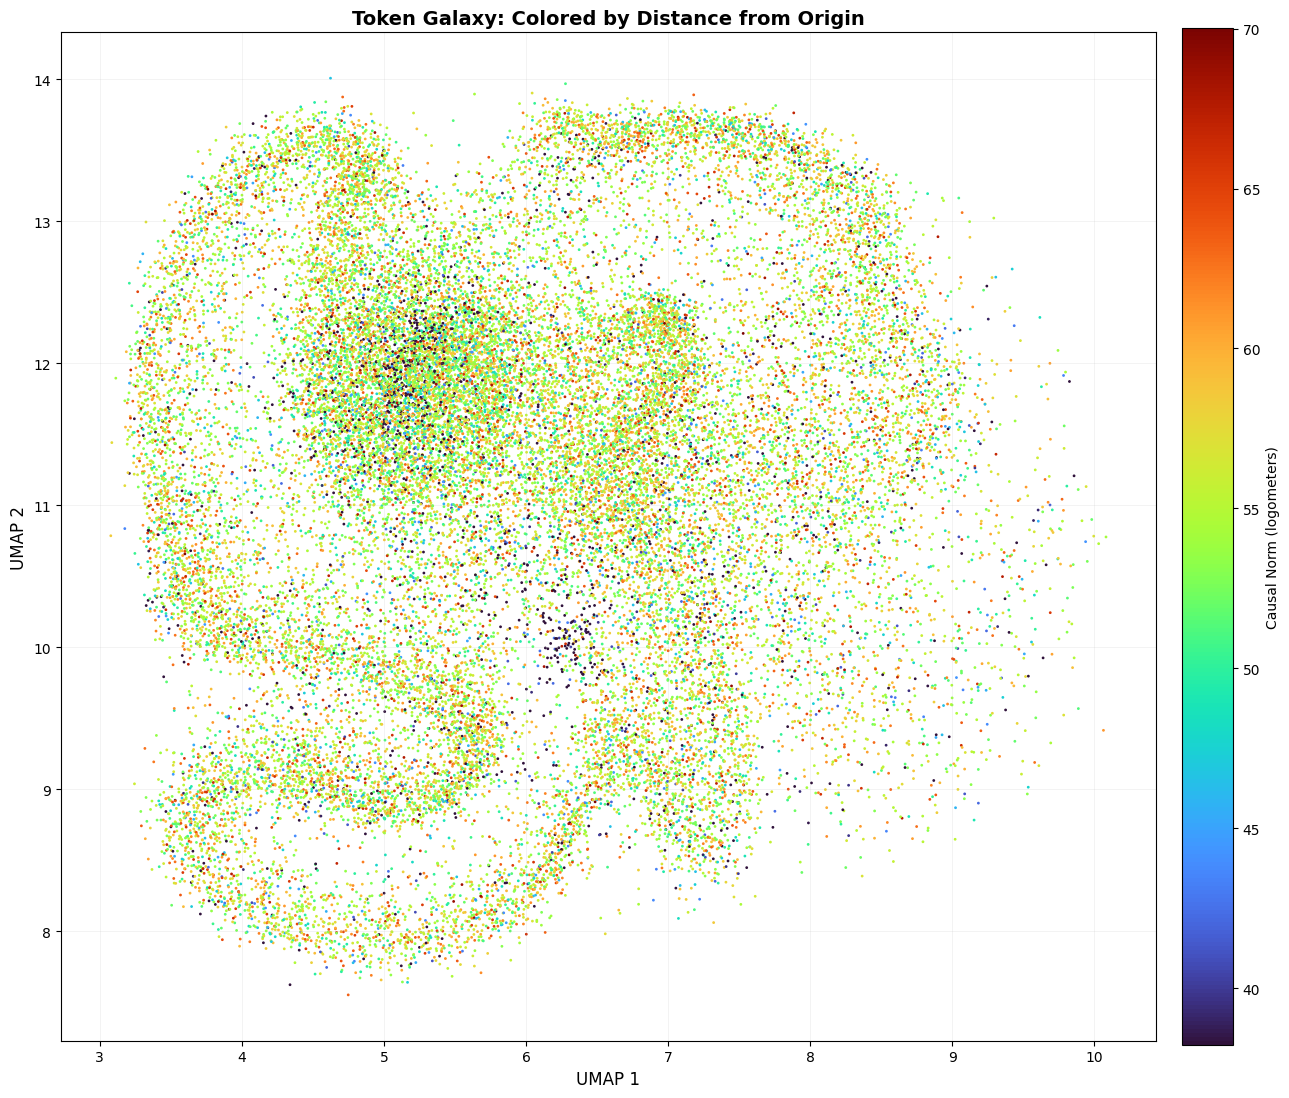

: 

In [ ]:
# Create blackbody colormap: black → red → orange → yellow → white
# (like a hot metal cooling: hot = white, cool = red, cold = black)
colors = ['#000000', '#8B0000', '#FF4500', '#FFD700', '#FFFFFF']
blackbody = LinearSegmentedColormap.from_list('blackbody', colors, N=256)

fig, ax = plt.subplots(figsize=(14, 11))

vmin = causal_norms.mean() - 2 * causal_norms.std()
vmax = causal_norms.mean() + 2 * causal_norms.std()
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=causal_norms,
    cmap='turbo', vmin=vmin, vmax=vmax,
    alpha=1.0,
    rasterized=True
)

cbar = plt.colorbar(scatter, ax=ax, label='Causal Norm (logometers)', pad=0.02)
cbar.ax.tick_params(labelsize=10)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('Token Galaxy: Colored by Distance from Origin', 
             fontsize=14, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

## Summary

This notebook visualizes the UMAP embedding colored by causal norm.

**Key questions:**
- Is there a radial structure (gradient from black to white)?
- Or is color mixed uniformly (suggesting the ~4% CV is just noise)?
- Does the "snake" hypothesis show temperature structure along its length?